In [ ]:
!pip install -q mlbench

In [2]:
import mlbench

## basics

### let's start with a tiny 2-instance binary classification dataset

In [3]:
m = mlbench.eval_binary(
    y_true=[True, False],
    y_pred=[True, False],
)
m

BalancedAccuracyBinary(✅ 1.00 does beat the baseline 0.50 (100%), ❌ not stat sig , 1 experiment metric: 1.0, 2 data instances 👎)

In [4]:
m.report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,1.0,0.50,0.5
stat sig,❌,NaN,0.05,NaN
experiment count,❌,1.0,3.00,-2.0
data size,❌,2.0,100.00,-98.0


- predictions and ground truth are exactly the same, so [Balanced Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) (BA) is 1.0 (max possible).
- baseline for BA is 0.5
- 100% (i.e. 1 out of 1) of the experiments (we'll see more about this soon) beat the baseline
- the results are not considered stat sig since we only have 1 experiment
- we only have 2 data instances, which is not great (we need moar)

### why did you compute Balanced Accuracy?
prefer some other metric? here's how to get the other available options

In [5]:
mlbench.get_eval_binary_metrics()

{'accuracy', 'auroc', 'average_precision', 'balanced_accuracy'}

### let's try [average precision](https://medium.com/@amirziai/ranking-metrics-from-first-principles-average-precision-32ad65fd18b6)

In [6]:
mlbench.eval_binary(
    y_true=[True, False],
    y_pred=[0.99, 0.2],
    metric="average_precision",
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,1.0,0.75,0.25
stat sig,❌,NaN,0.05,NaN
experiment count,❌,1.0,3.00,-2.00
data size,❌,2.0,100.00,-98.00


### how do I run more than 1 experiment?

In [7]:
mlbench.eval_binary(
    y_true=[True, False],
    y_pred=[[True, False], [True, False], [True, False]],
    metric="balanced_accuracy",
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,1.0,0.50,0.50
stat sig,✅,0.0,0.05,0.05
experiment count,✅,3.0,3.00,0.00
data size,❌,2.0,100.00,-98.00


- `y_pred` can be a list of lists (or numpy arrays)
- each element in the outer list represents an experiment
- e.g. in this example we've done 3 experiments
- since all 3 are perfect predictions there's no variance and the results are stat sig

## toy dataset
let's try something a bit more realistic

In [8]:
import numpy as np
import pandas as pd

In [9]:
from sklearn.datasets import load_breast_cancer

### a binary classification task

In [10]:
data = load_breast_cancer()
x, y = data.data, data.target.astype(bool)
x.shape

(569, 30)

### this is what the features look like for reference
we're not going to use the features tho, it's just to give you an idea.

In [11]:
pd.DataFrame(x).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### labels are binary

In [12]:
y[:5]

array([False, False, False, False, False])

### positive rate

In [13]:
np.mean(y)

0.6274165202108963

### how would a constant predictor do?
this predictor always predicts the majority class

In [14]:
y_constant_true = [True] * len(y)

In [15]:
mlbench.eval_binary(
    y_true=y,
    y_pred=y_constant_true,
).report

,pass,value,threshold,gain
check,,,,
beat baseline,❌,0.5,0.50,0.0
stat sig,❌,NaN,0.05,NaN
experiment count,❌,1.0,3.00,-2.0
data size,✅,569.0,100.00,469.0


### how would a random predictor do?

In [16]:
def get_y_rand(y):
    p = np.mean(y)
    return np.random.choice([True, False], size=len(y), p=[p, 1-p])

### you'd expect to get 0.5

In [17]:
np.random.seed(0)
mlbench.eval_binary(
    y_true=y,
    y_pred=get_y_rand(y),
).report

,pass,value,threshold,gain
check,,,,
beat baseline,❌,0.499531,0.50,-0.000469
stat sig,❌,NaN,0.05,NaN
experiment count,❌,1.000000,3.00,-2.000000
data size,✅,569.000000,100.00,469.000000


### not always tho, it's random after all

In [18]:
np.random.seed(4)
mlbench.eval_binary(
    y_true=y,
    y_pred=get_y_rand(y),
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,0.51427,0.50,0.01427
stat sig,❌,NaN,0.05,NaN
experiment count,❌,1.00000,3.00,-2.00000
data size,✅,569.00000,100.00,469.00000


### we shouldn't be able to get stat sig results with random guessing

In [20]:
np.random.seed(4)
exp1 = get_y_rand(y)
exp2 = get_y_rand(y)
exp3 = get_y_rand(y)
mlbench.eval_binary(
    y_true=y,
    y_pred=[exp1, exp2, exp3],
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,0.510857,0.50,0.010857
stat sig,❌,0.210257,0.05,-0.160257
experiment count,✅,3.000000,3.00,0.000000
data size,✅,569.000000,100.00,469.000000


In [23]:
np.random.seed(0)
mlbench.eval_binary(
    y_true=y,
    y_pred=[get_y_rand(y) for _ in range(10)],
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,0.502177,0.50,0.002177
stat sig,❌,0.332722,0.05,-0.282722
experiment count,✅,10.000000,3.00,7.000000
data size,✅,569.000000,100.00,469.000000


### a perfect predictor that can nail the predictions across 10 experiments
this is stat sig

In [24]:
mlbench.eval_binary(
    y_true=y,
    y_pred=[y] * 10,
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,1.0,0.50,0.50
stat sig,✅,0.0,0.05,0.05
experiment count,✅,10.0,3.00,7.00
data size,✅,569.0,100.00,469.00


### that's too easy, let's distort the predictions a bit
this way we can simulate how well a model with a certain level of error does

In [25]:
def get_y_distorted(y, p):
    mask = np.random.choice([True, False], size=len(y), p=[p, 1-p])
    return np.where(mask, ~y, y)

### a model with 5% error

In [32]:
np.random.seed(0)
mlbench.eval_binary(
    y_true=y,
    y_pred=[get_y_distorted(y=y, p=0.05) for _ in range(10)],
).report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,9.502689e-01,0.50,0.450269
stat sig,✅,1.495615e-19,0.05,0.050000
experiment count,✅,1.000000e+01,3.00,7.000000
data size,✅,5.690000e+02,100.00,469.000000


### model with 40% error

In [34]:
np.random.seed(0)
good = mlbench.eval_binary(
    y_true=y,
    y_pred=[get_y_distorted(y=y, p=0.4) for _ in range(10)],
)
good.report

,pass,value,threshold,gain
check,,,,
beat baseline,✅,5.977439e-01,0.50,0.097744
stat sig,✅,6.115514e-08,0.05,0.050000
experiment count,✅,1.000000e+01,3.00,7.000000
data size,✅,5.690000e+02,100.00,469.000000


### visualize
- shows the metric distribution across the 10 experiments
- note that all fall in the green zone (i.e. above the baseline value of 0.5)
- the blue / purple region indicates the inter quartile range IQR
- IQR is the region between 25th and 75th percentile of results (similar to a boxplot)

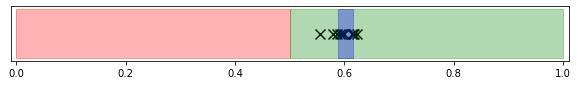

In [35]:
good.draw()

### how about a model with 50% error

In [37]:
np.random.seed(0)
bad = mlbench.eval_binary(
    y_true=y,
    y_pred=[get_y_distorted(y=y, p=0.50) for _ in range(10)],
)
bad.report

,pass,value,threshold,gain
check,,,,
beat baseline,❌,0.493484,0.50,-0.006516
stat sig,❌,0.827176,0.05,-0.777176
experiment count,✅,10.000000,3.00,7.000000
data size,✅,569.000000,100.00,469.000000


### visualization shows that we don't have a reliable model
intuitively this matches up with the fact that the results are not stat sig

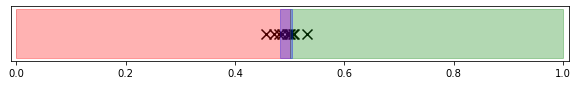

In [38]:
bad.draw()

### remove IQR to see things a bit more clearly

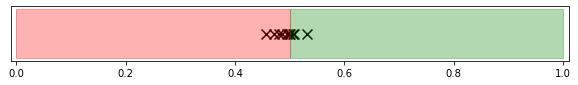

In [39]:
bad.draw(p_low=None, p_high=None)